In [172]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

In [2]:
local_path = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/energy_generation_data/df_deutschland.csv'

df = pd.read_csv(local_path)

df['Date'] = pd.to_datetime(df.Date)

df.head()

,Date,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
0,2015-01-01,11.989583,1278.427083,75.531250,50hertz
1,2015-01-02,9.947917,2555.510417,17.677083,50hertz
2,2015-01-03,11.281250,2308.958333,27.354167,50hertz
3,2015-01-04,11.354167,2079.041667,49.750000,50hertz
4,2015-01-05,4.104167,1333.343750,20.187500,50hertz


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8772 entries, 0 to 8771
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                8772 non-null   object 
 1   Wind offshore[MWh]  4386 non-null   float64
 2   Wind onshore[MWh]   8772 non-null   float64
 3   Photovoltaics[MWh]  8772 non-null   float64
 4   region              8772 non-null   object 
dtypes: float64(3), object(2)
memory usage: 342.8+ KB


In [11]:
generation_df = df.groupby(by=df['Date'].dt.date).sum()
generation_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01,130.437500,3112.937500,178.093750
2015-01-02,107.791667,6163.031250,80.979167
2015-01-03,126.270833,4761.447917,75.510417
2015-01-04,120.364583,3948.895833,208.354167
2015-01-05,80.937500,2288.208333,276.479167


In [20]:
wind_df = generation_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
wind_df

Date
2015-01-01    3243.375000
2015-01-02    6270.822917
2015-01-03    4887.718750
2015-01-04    4069.260417
2015-01-05    2369.145833
                 ...     
2020-12-28    3283.010417
2020-12-29    3296.229167
2020-12-30    4859.833333
2020-12-31    3267.677083
2021-01-01     842.864583
Length: 2193, dtype: float64

In [315]:
wind_df = wind_df * 24

Date
2015-01-01    3243.375000
2015-01-02    6270.822917
2015-01-03    4887.718750
2015-01-04    4069.260417
2015-01-05    2369.145833
                 ...     
2020-12-28    3283.010417
2020-12-29    3296.229167
2020-12-30    4859.833333
2020-12-31    3267.677083
2021-01-01     842.864583
Length: 2193, dtype: float64

In [ ]:
features_df = pd.read_csv('/Users/R/code/HaukeFock/predict_energy_generation/raw_data/features/winddailyofeverystation.csv')

#features_df = features_df.sum(axis=1)
features_df.Date = pd.to_datetime(features_df.Date)

features_df.index = features_df.Date
features_df.drop(columns=['Date'], inplace=True)

In [279]:
feat = np.log(features_df.mean(axis=1))

# Statistical exploration

In [246]:
train_size = 0.7
index = round(train_size*wind_df.shape[0])
wind_df_train = np.log(wind_df.loc[:dt.date(2016,1,1)])
wind_df_test = np.log(wind_df.loc[dt.date(2016,1,1):dt.date(2016,3,1)])

y = np.log(wind_df.loc[:dt.date(2016,3,1)])
y_train = wind_df_train
y_test = wind_df_test

## Test stationarity

### Visually

<AxesSubplot:>

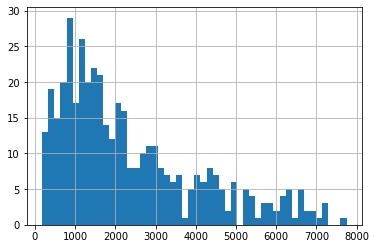

In [243]:
y.hist(bins=50)

<AxesSubplot:xlabel='Date'>

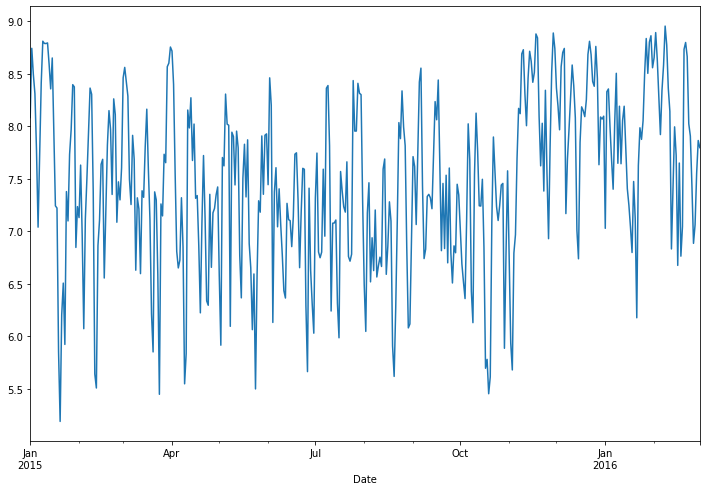

In [247]:
plt.subplots(figsize=(12,8))
y.plot()

###  Calculations (mean, variance and autocorrelation)

In [241]:
mean = y.mean()
#print(mean)

year = 2020
month = 1
day = 1

mean_2 = y.loc[dt.date(year,month,day):dt.date(year+1,month,day)].mean()

mean_2/mean

1.2550978218375204

In [264]:
# p-value (should be less than 0.05 to be sattionary)
adfuller(y_train)[1]

5.599466242515729e-15

In [240]:
p_val = adfuller(y)[1] 
p_val #seems to be stationary (p-value below 0.05) 

0.0003649044190566608

In [249]:
var = y.var()
var

0.656594434581068

In [184]:
year = 2020
adfuller(y.loc[dt.date(year,1,1):dt.date(year+1,1,1)])[1]

1.7853881667479785e-07

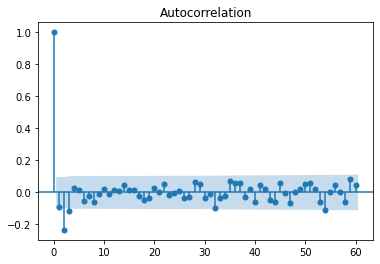

In [263]:
plot_acf(y.diff(1).dropna(), lags=60);

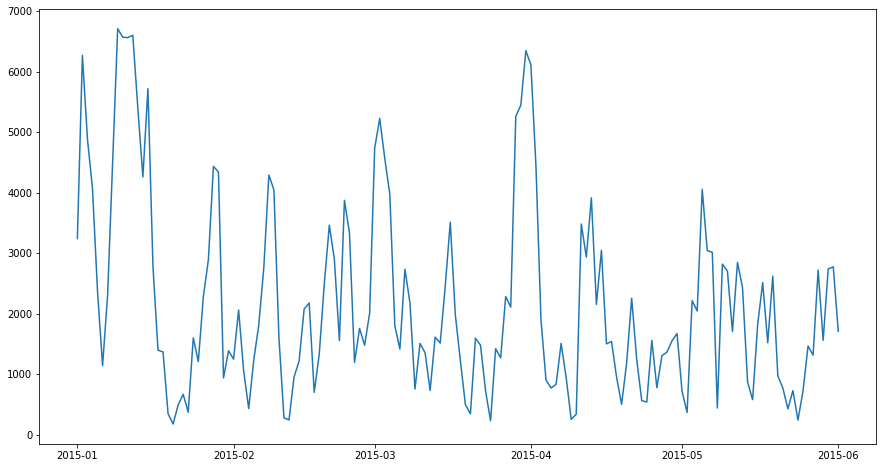

In [133]:
plt.subplots(figsize=(15,8))
plt.plot(y.loc[:dt.date(2015,6,1)])

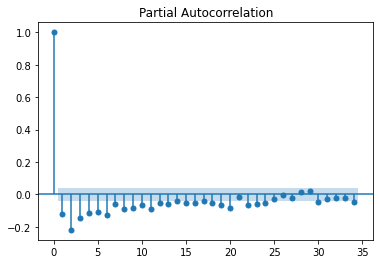

In [110]:
plot_pacf(y.diff(1).dropna())
plt.show()

In [72]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m)
    if d > 0:
        for i in range(d):
            y = y.diff(1)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

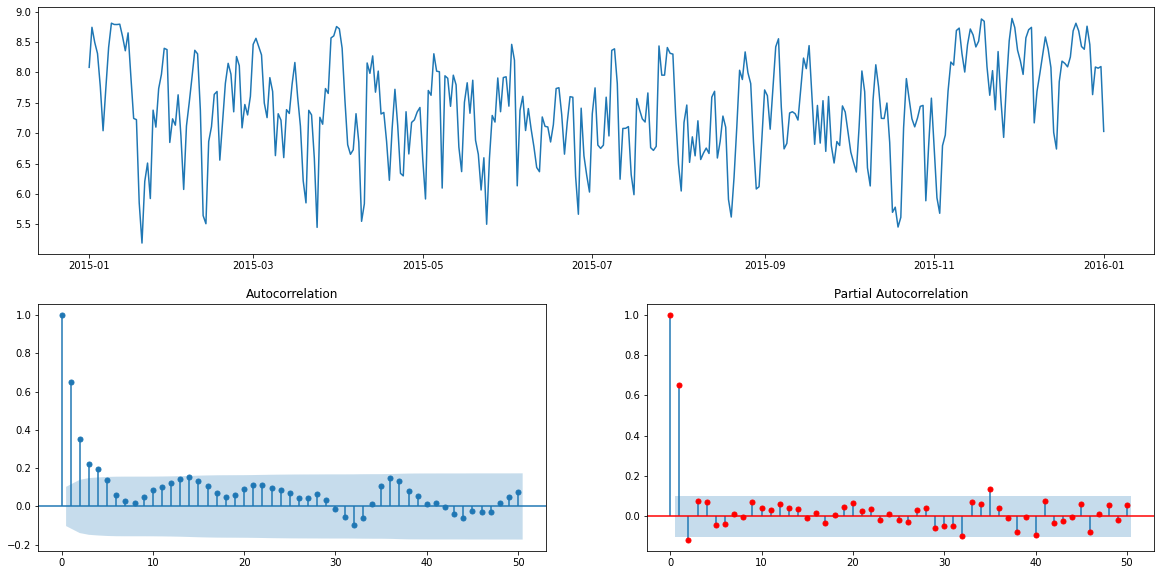

In [251]:
plot_autocorrelation(y_train, D=0, m=365*5)

In [291]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=12, X=exog.to_numpy().reshape(-1,1),
                       start_p=0, max_p=2,
                       start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=146.880, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=143.973, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=137.085, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=117.930, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=141.974, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=116.710, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=118.152, Time=0.45 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=117.648, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=52.496, Time=0.27 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=54.154, Time=0.78 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=54.059, Time=0.62 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=56.420, Time=0.83 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=in

In [131]:
y.index = pd.to_datetime(y.index)

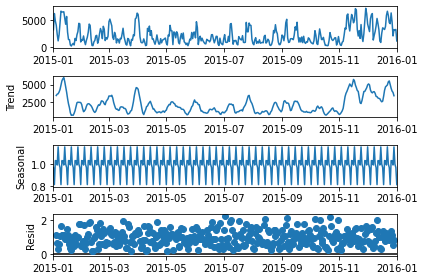

In [170]:
result_mul = seasonal_decompose(y[:dt.date(2016,1,1)], model='multiplicative')
result_mul.plot();

# Models

## ARIMA

In [254]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(y_train, order=(1,1,2)).fit()
arima.summary()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  365
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -338.123
Method:                       css-mle   S.D. of innovations              0.610
Date:                Sat, 22 May 2021   AIC                            686.245
Time:                        15:32:57   BIC                            705.745
Sample:                    01-02-2015   HQIC                           693.995
                         - 01-01-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.342      0.733      -0.004       0.006
ar.L1.D.y      0.4556      0.080      5.721      0.000       0.300       0.612
ma.L1.D.y     -0.7324      0.083     -8.773      0.000      -0.896      -0.569
ma.L2.D.y     -0.2281      0.076     -3.010      0.003      -0.377      -0.080
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1948           +0.0000j            2.1948            0.0000
MA.1            1.0330           +0.0000j            1.0330            0.0000
MA.2           -4.2432           +0.0000j            4.2432            0.5000
-----------------------------------------------------------------------------
"""

In [289]:
exog = feat.loc[:dt.date(2016,1,1)]
exog.shape

(366,)

In [292]:
sarimax = SARIMAX(endog=y_train, exog=exog, order=(1,1,3)).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [294]:
exog_test = feat.loc[dt.date(2016,1,1):dt.date(2016,3,1)]

y_pred = sarimax.forecast(y_test.shape[0], exog=exog_test)[0]

In [237]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [298]:
forecast = sarimax.forecast(len(y_test), exog=exog_test, alpha=0.05)

In [299]:
forecast

2016-01-02    6.971224
2016-01-03    8.525849
2016-01-04    8.618108
2016-01-05    8.381930
2016-01-06    7.973859
                ...   
2016-02-27    7.094627
2016-02-28    7.306010
2016-02-29    7.799631
2016-03-01    8.269325
2016-03-02    7.957582
Freq: D, Name: predicted_mean, Length: 61, dtype: float64

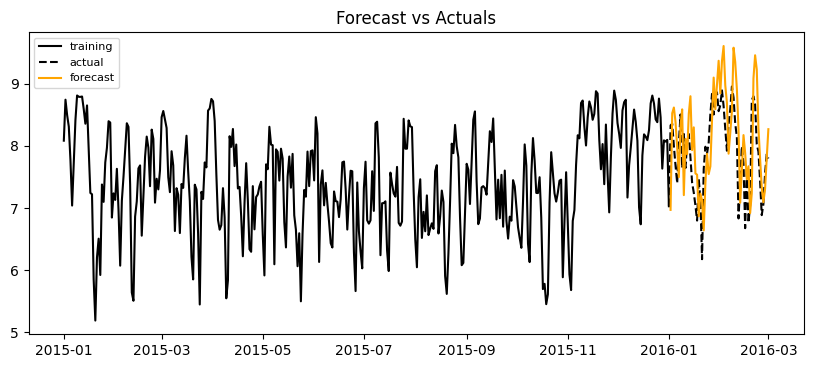

In [300]:
plot_forecast(forecast, y_train, y_test)

In [ ]:
plot()

In [303]:
y_test.describe()

count    61.000000
mean      7.904558
std       0.666655
min       6.178009
25%       7.435260
50%       7.986958
75%       8.505100
max       8.955280
dtype: float64

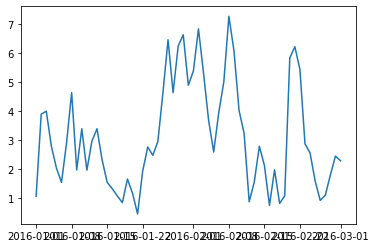

In [302]:
residuals = y_test - y_pred
plt.plot(np.exp(residuals))

In [349]:
sarimax.mae

0.21627927588140602

In [347]:
mae(y_test, forecast)

0.2956947194044079

In [316]:
sarimax.mse

0.12587164764678885

In [343]:
mse(y_test, forecast)

0.13110519959229167

In [346]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [341]:
baseline = mean_absolute_percentage_error(y_test, forecast)
baseline

3.7320740652313935